In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

This notebook aims to do the following
1. Replicate (most) of the work done in the colab file
2. Integrate the blair model embedding as inputs
3. Use our input files (product and user) metadata instead of the hugging face ones 


# Imports

In [2]:
import pandas as pd
import torch
import random

from datasets import load_dataset
from utils.setup_graph import make_mapping, create_nodes, train_test_validation_split
from utils.setup_embeddings import instantiate_users, custom_BLaIR_text_embedding_model
from utils.graph_model import BaseGNNRecommender, GNNSAGERecommender
from utils.graph_helpers import train_model, plot_loss, final_evaluation
from utils.recomendations import recommend_products, pretty_print_recomendations, paper_evaluation

/home/viknesh/.venv_ls/dl_proj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load dataset

Original data as obtained from the colab notebook  
Additional data is obtained from the `All_Beauty_cleaned data` folder. 

In [3]:
reviews_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)
product_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_All_Beauty", split="full", trust_remote_code=True)

review_df = reviews_dataset['full'].to_pandas()
product_df = product_dataset.to_pandas()

In [4]:
agg_user_df = pd.read_csv("data/user_metadata.csv")
new_product_df = pd.read_csv("data/product_metadata.csv")

In [5]:
review_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [6]:
product_df.sample(2)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
90598,All Beauty,Brazilian Body Wave Virgin Hair 3 Bundles 8A G...,2.6,2,[],[],None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",nice hair,[],"{""Brand"": ""Nice hair"", ""Material"": ""Human Hair...",B08GP2DHYF,None,None,None
13477,All Beauty,Peach Bloom Color Blossoming Lip & Cheek Tint,3.7,11,[],[Color Blossoming Lip & Cheek Tint Details HOW...,22.0,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Too Faced,[],"{""Brand"": ""Too Faced"", ""Color"": ""Peach Glow"", ...",B08SC7H9VY,None,None,None


In [7]:
agg_user_df.head()

,user_id,rating_mean,rating_count,helpful_vote_mean,helpful_vote_gte_1,verified_purchase_mean,last_active_in_days_min,last_active_in_days_max,word_count_mean,reviews
0,AE222BBOVZIF42YOOPNBXL4UUMYA,5.0,1,0.0,0,1.0,2739,2739,8.0,Five Stars Great product....excellent price fo...
1,AE222FP7YRNFCEQ2W3ZDIGMSYTLQ,5.0,1,0.0,0,1.0,185,185,6.0,Nice consistency and great smell [[VIDEOID:8b3...
2,AE222X475JC6ONXMIKZDFGQ7IAUA,5.0,1,2.0,1,1.0,2436,2436,4.0,Wow It tastes good
3,AE222Y4WTST6BUZ4J5Y2H6QMBITQ,4.0,1,1.0,1,1.0,3728,3728,34.0,Lensoclean Unit The cleaning unit does a good ...
4,AE2232TEZOEWQLAFEX2NA6VBGMYQ,5.0,1,0.0,0,1.0,1501,1501,7.0,Sus colores Son como en la foto


In [8]:
new_product_df.head()

,parent_asin,meta,reviews
0,0124784577,WOW Organics Apple Cider Vinegar Shampoo - 300 mL,Product delivers Makes my hair look healthy ||...
1,0692508988,The Listening Cards The Listening Cards are an...,Delightful and Profound This is a wonderful to...
2,069267599X,Inspirational Card Deck Nicole Piar created th...,Sigh I soo much wanted to Really love this dec...
3,0764490117,Kingdom Rock Starter Kit: Where Kids Stand Str...,Amazing VBS kit! We just completed our week of...
4,0816091846,"Sissy Spacek Collection - Raggedy Man, The Riv...","Wish she would'a done comedy, too! Spacek can ..."


In [9]:
print('review df len:\t\t', len(review_df))
print('product df len:\t\t', len(product_df))
print("agg user df len:\t", len(agg_user_df))
print("new product df len:\t", len(new_product_df))

review df len:		 701528
product df len:		 112590
agg user df len:	 631986
new product df len:	 89060


So we now want to transfor the dataset to the columns / how we want them to be 

**review_df**  
This is the original df used.  
We only need to know the user to product mapping (node to node) and the rating (edge weight) 

**product_df**  
I elect not to use it because the new product df might be a better source (cleaned i guess)   
kept some columns for the pretty print of recomendations 

**agg_user_df**  
I take the aggregated data as the start embeddings.   
self note / to do: a method to also create a blank user start embedding as seen in the colab  

**new product df**  
used as is given 

In [10]:
edge_list_df = review_df[["user_id", "parent_asin", "rating"]].copy()

In [11]:
user_node_content_df = agg_user_df.drop("reviews", axis = 1).copy()

In [12]:
product_title_df = product_df[["parent_asin", "title"]].copy()

In [13]:
product_node_content_df = new_product_df.copy()

In [14]:
# memory saving 
del reviews_dataset, product_dataset, product_df, new_product_df, agg_user_df, review_df

# Making the nodes 

In [15]:
user_mapping = make_mapping(user_node_content_df, "user_id")
product_mapping = make_mapping(product_node_content_df, "parent_asin")

In [16]:
reverse_product_mapping = {idx: asin for asin, idx in product_mapping.items()}

In [17]:
print('No of unique users:', len(user_mapping))
print('No of unique products:', len(product_mapping))

No of unique users: 631986
No of unique products: 89060


The number of users is the same  
The number of unique products is smaller (original 112590)  
So we need to do a sanity check (just in case)

In [18]:
# I have edges without a correspodning data entry in the product node contnet 
sum(~edge_list_df.parent_asin.isin(product_node_content_df.parent_asin))

66265

In [19]:
reduced_edge_list_df = edge_list_df[edge_list_df.parent_asin.isin(product_node_content_df.parent_asin)].reset_index(drop=True)

In [20]:
print("Remaining edge list percentage:", round(len(reduced_edge_list_df) / len(edge_list_df) * 100, 3))

Remaining edge list percentage: 90.554


The actual making of the nodes and edges 

In [21]:
user_nodes = create_nodes(user_mapping, reduced_edge_list_df, "user_id")
product_nodes = create_nodes(product_mapping, reduced_edge_list_df, "parent_asin")
edge_index = torch.tensor([user_nodes, product_nodes], dtype=torch.long)
edge_weights = torch.tensor(reduced_edge_list_df.rating.values, dtype=torch.float)

# Making the embeddings 

In the colab notebook, there was a `product category embedding`.   
This column does not exist in the new product df that we are using so not included.  
Perhaps we need a flow to do experiments with how the data used can affect performance 

The embedding process is long and expensive.  
So there is an additional notebook to conver it all into embeddings.  
Here were just load the files 

User embeddings is fast (since all numbers) so no pre computation

In [22]:
## Loading of the variables 
## for the timebeing we take a sample
# meta_features = custom_BLaIR_text_embedding_model(product_node_content_df["meta"], "custom_blair/massive", batch_size = 512, max_length = 512) # 1h 30 min 
# review_features = custom_BLaIR_text_embedding_model(product_node_content_df["reviews"], "custom_blair/massive", batch_size = 512, max_length = 512) # 10 min

# temporary
# torch.save(meta_features, "data/embeddings/meta_features_512.pt")
# torch.save(review_features, "data/embeddings/review_features_512.pt")

meta_features = torch.load("data/embeddings/meta_features_512.pt")
review_features = torch.load("data/embeddings/review_features_512.pt")

In [23]:
# join back i guess
product_features = torch.cat([meta_features, review_features], dim=1)

In [24]:
user_features = instantiate_users(user_node_content_df)

# Train test validation splits 

In [25]:
train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, test_edge_index, test_edge_weights = train_test_validation_split(edge_index, edge_weights)

# Set up variables

In [26]:
num_users = len(user_mapping)
num_products = len(product_mapping)
user_feature_dim = user_features.shape[1]
product_feature_dim = product_features.shape[1]

# Move to GPU 

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
val_edge_index = val_edge_index.to(device)
val_edge_weights = val_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)
user_features = user_features.to(device)
product_features = product_features.to(device)

# Run the models

This is a copy paste of the models in the notebooks, no changes to logic.  
Modificiations if made is mainly for the function wrappers or stuff 

Tried batching, but it ended up not being that effective.   
Code works but slow.    
It was written in case not enough memory but guess right now might not be needed - gpu works on full set one shot 

In [28]:
# Base GNN
base_gnn_model = BaseGNNRecommender(num_users, num_products, user_feature_dim,product_feature_dim)
optimizer = torch.optim.Adam(base_gnn_model.parameters(), lr=0.01)

In [29]:
base_gnn_model.to(device)
train_loss, valid_loss, best_model = train_model(base_gnn_model, train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, 
                                                 user_features, product_features, num_epochs = 100, print_progress=True)

Epoch: 10, Train Loss: 51.7347, Val Loss: 6.0002, best model epoch: 10
Epoch: 20, Train Loss: 10.2693, Val Loss: 10.0156, best model epoch: 18
Epoch: 30, Train Loss: 5.4053, Val Loss: 4.5490, best model epoch: 18
Epoch: 40, Train Loss: 2.9647, Val Loss: 2.4694, best model epoch: 39
Epoch: 50, Train Loss: 2.9621, Val Loss: 2.3196, best model epoch: 39
Epoch: 60, Train Loss: 2.6631, Val Loss: 2.2658, best model epoch: 58
Epoch: 70, Train Loss: 2.5599, Val Loss: 2.2316, best model epoch: 70
Epoch: 80, Train Loss: 2.5241, Val Loss: 2.2266, best model epoch: 75
Epoch: 90, Train Loss: 2.4737, Val Loss: 2.2224, best model epoch: 85
Epoch: 100, Train Loss: 2.4633, Val Loss: 2.2167, best model epoch: 95


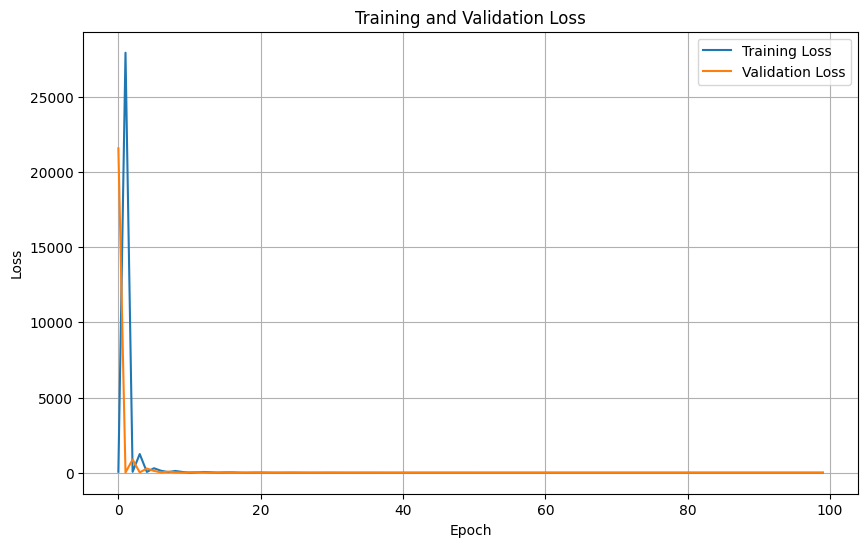

In [30]:
plot_loss(train_loss, valid_loss) # SAGE

In [31]:
final_evaluation(base_gnn_model, test_edge_index, test_edge_weights, user_features, product_features, best_model)

Test loss: 2.2265
Best possible loss: 2.2265


In [32]:
# SAGE GNN
GNNSAGE_model = GNNSAGERecommender(num_users, num_products, user_feature_dim, product_feature_dim)
optimizer = torch.optim.Adam(GNNSAGE_model.parameters(), lr=0.01)

In [33]:
GNNSAGE_model.to(device)
train_loss, valid_loss, best_model = train_model(GNNSAGE_model, train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, 
                                                 user_features, product_features, num_epochs = 100, print_progress=True)

Epoch: 10, Train Loss: 2.9053, Val Loss: 3.3395, best model epoch: 9
Epoch: 20, Train Loss: 3.0401, Val Loss: 2.3410, best model epoch: 17
Epoch: 30, Train Loss: 2.5028, Val Loss: 2.2475, best model epoch: 27
Epoch: 40, Train Loss: 2.3745, Val Loss: 2.2003, best model epoch: 39
Epoch: 50, Train Loss: 2.3299, Val Loss: 2.1629, best model epoch: 50
Epoch: 60, Train Loss: 2.2917, Val Loss: 2.1666, best model epoch: 56
Epoch: 70, Train Loss: 2.2477, Val Loss: 2.1547, best model epoch: 66
Epoch: 80, Train Loss: 2.2227, Val Loss: 2.1328, best model epoch: 80
Epoch: 90, Train Loss: 2.1799, Val Loss: 2.1403, best model epoch: 89
Epoch: 100, Train Loss: 2.1317, Val Loss: 2.1297, best model epoch: 96


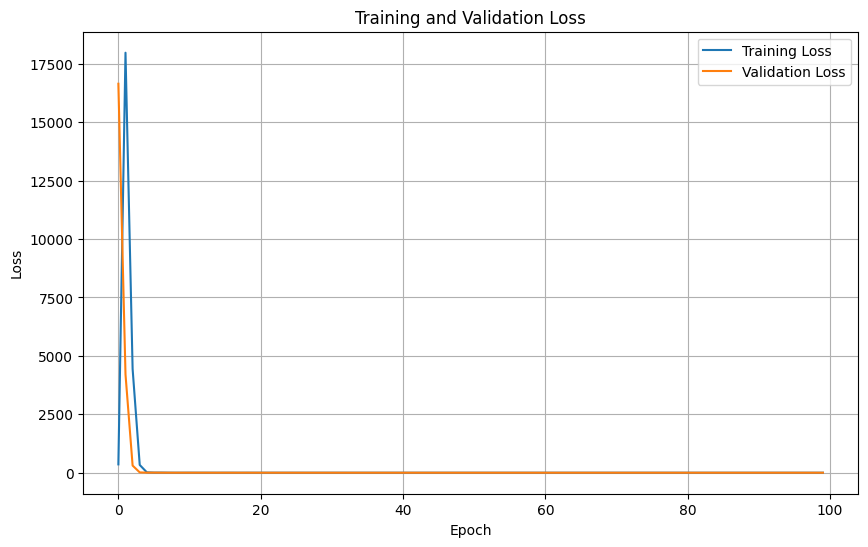

In [34]:
plot_loss(train_loss, valid_loss) # base GNNM

In [35]:
final_evaluation(GNNSAGE_model, test_edge_index, test_edge_weights, user_features, product_features, best_model)

Test loss: 2.1404
Best possible loss: 2.1404


# Next recomendations 

Based on the current set up, actually very trash cos the model predicts the exact same stuff (base GNN)  
GNNSAGE not say much better still alternates the same stuff

In [49]:
user_id = user_node_content_df.user_id.sample(1).item()
print(user_id, "\n")
recomendations = recommend_products(base_gnn_model, user_id, user_mapping, product_mapping,
                                     user_features, product_features, top_k=10)
pretty_print_recomendations(recomendations, product_title_df, "title")
print("\n")

recomendations = recommend_products(GNNSAGE_model, user_id, user_mapping, product_mapping,
                                     user_features, product_features, top_k=10)
pretty_print_recomendations(recomendations, product_title_df, "title")

AFFELEZLOK33MQTUBYESP4FEQQIA 

Product 1: Eau De Merveilles by Hermes Body Lotion 6.5 oz
Product 2: Konsait 9 Sets Mermaid Face Gems Glitter Face Stickers Crystals Face Jewels Rave Accessories Self Adhesive Glitter Rhinestone Temporary Tattoos for Eyes Face Body Forehead Make Up Festival Party
Product 3: ZLIME Face Cleansing Brush Face Wash Brush Waterproof 4 Spin Brush Head for Deep Cleansing Gentle Exfoliating Makeup Remove Massaging Blackheads Removal (Blue)
Product 4: Edge Shave Gel for Men Sensitive Pro Relief - 7 Ounce (Pack of 4)
Product 5: CLOTHOBEAUTY 30 pcs Pro makeup brushes pen guard protector meshes cover set, black sleeves(for medium/large sizes brushes)
Product 6: Michel Mercier Kids Detangling Brush Pink - For Normal Hair
Product 7: LiveFine Foot Spa Massager - Heated Bath, Automatic Massage Rollers, Rain Shower, Pumice Stone
Product 8: Truefitt & Hill Lavender Shaving Cream 190g/6.7oz
Product 9: Red Polka Dot Bow Clips for Baby Girls Toddlers Hair Clips Costume Accesso

# DCG@10 testing 

This section is not from the colab notebook.  
Works to figure out the dcg@10 metric to compare against the paper  

From what i see, we need to be able to pass in some form of sequence into the prection.  
My current understanding is limited on how to tweak it to make it as such.  
Instead perhaps what we can do is to treat the test set as the ground truth label itself   
And then we do the same calcualtions  

In [37]:
user_idx = random.choice(test_edge_index[0]).item()
actual_prods = test_edge_index[1, test_edge_index[0] == user_idx]
paper_evaluation(base_gnn_model, user_idx, actual_prods, len(product_mapping), user_features, product_features, top_k=10)

(0.0, 0.0)

In [38]:
# count = 0 
# for user_idx in test_edge_index[0]:
#     actual_prods = test_edge_index[1, test_edge_index[0] == user_idx]
#     scores = paper_evaluation(base_gnn_model, user_idx, actual_prods, len(product_mapping), user_features, product_features, top_k=10)
#     if scores[0] > 0 or scores[1] > 0:
#         print(user_idx, scores)
#         count += 1
#     if count == 5:
#         break